## One-dimensional hyperbolic systems

### Advection equation

First we are going to study the one-dimensional advection equation 
\begin{align}
     \frac{\partial }{\partial t} n= - a \frac{\partial}{\partial x} n 
 \end{align}
We are going to compare the first order upwind scheme with a centered differences scheme. Since forward in time centered in space is unconditionally unstable we add artificial diffusion to the latter.
 We discretize space with a cell-centered grid on the domain $[-L_\parallel /2 ; L_\parallel/2]$, where $L_\parallel = 2\pi q R_0$ with $q=3$ and $R_0=0.545$m approximating the length of a fieldline from divertor to divertor in the Compass SOL. We use $N_x$ points.
 
 In time we use the Bogacki-Shampine adaptive method of order 3 (adaption of order 2).
 
 We use Neumann boundary conditions and as initial condition we use the classical problem of a step function
 \begin{align}
    n(x,0) = \begin{cases} 1 \text{ for } x < x_a \\ 0 \text{ else}\end{cases}
 \end{align}
 
 As an alternative initial condition we can choose a wave function
 \begin{align}
     n(x,0) = n_0 + A \sin( k(x-x_0))
 \end{align}
    
We also remark that the advection equation has a simple analytical 
solution
\begin{align}
    n(x,t) = n(x-at, 0)
\end{align}

In order to run this notebook locally you will need
- a local instsallation of feltor: follow the quick-start guide https://github.com/feltor-dev/feltor (we do need jsoncpp and netcdf, but not glfw, and a link to path/to/feltor/inc/dg in home/include)
- a local installation of simplesimdb: follow the quick-start guide https://github.com/mwiesenberger/simplesimdb
- to compile the cpp codes in this repository: type make in a shell

In [1]:
import numpy as np
import simplesimdb as simplesim
from netCDF4 import Dataset
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import matplotlib.animation as animation
# import feltorutilities as fp
from scipy.integrate import solve_ivp

In [2]:
# The code continuity.cpp discretizes the continuity equation
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_continuity_input() :
    return {
    "grid" : {
        "Nx" : 32, # number of grid points
        "x" : [0, 1], # spatial domain [x_0,x_1]
        "bc" : "NEU" # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
    },
    "init": # initial condition
    {
        "type":"step", 
        "x_a" : 0.25 # location of step
#         "type" : "wave",
#         "n_0" 1.0,
#         "amp" : 1.0
#         "k"   : 1.0
#         "x_0" : 1.0
    },
    "advection" : { # numerical discretization
        "type" : "upwind",
        # upwind (classical 1st order upwind)
        # upwind2 (2nd order upwind formula)
        # centered (2nd order centered differences)
    },
    "timestepper":
    {
        # We implemented an adaptive embedded Runge Kutta method
        # (see the following link for a list)
        #https://feltor-dev.github.io/doc/dg/html/structdg_1_1_e_r_k_step.html
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-5,
        "atol" : 1e-6
        
    },
    "physical":
    {
        "velocity" : 1.0, # a in Eq. 1
        "nu" : 0.0 
        # if non-zero a diffusion term is added to Eq. 1
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.25, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }


In [3]:
# Let us run our first simulation and get an overview over
# the output file.

# We run simulations using the simplesimdb library
# In order for this to work you must first compile
# the code as described above, type:
# make continuity

# The simplesimdb library provides a simple python interface to the
# code via the Repeater class
# https://github.com/mwiesenberger/simplesimdb
rep = simplesim.Repeater("./continuity","temp.json", "temp.nc")
# in the following the temp.json and temp.nc files will be
# re-used for every simulation
rep.clean() # delete previously existing files
rep.run( make_continuity_input(), error="display", stdout="ignore")
# this will (i) write the input parameters to "temp.json"
# (ii) run the code, which
# (iii) produces the file "temp.nc"
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
# Now with the help of pythons netcdf library we can pretty print
# an overview of output file
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Number of failed steps
duration (21,) 	Computation time for the latest output (i.e. nsteps timesteps)
nsteps (21,) 	Number of calls to the timestepper (including failed steps)
numerical (21, 32) 	Numerical solution: Advected variable
analytical (21, 32) 	Analytical solution


In [4]:
# Here we define a simple plot routine
# It loops over all parameter sets that we give it, runs the
# corresponding simulation and then plots the analytical and
# numerical solutions at the last timestep
def plot_upwind( p_list):
    frows = 1
    fcols = 1

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        x = ncin.variables["x"][:]
        analytic = ncin.variables["analytical"][:,:]
        last_idx = ncin.variables["time"].shape[0]-1
        numerical = ncin.variables["numerical"][:,:]
        if not plotted :
            im = ax.plot(x,analytic[last_idx,:], color='k',
                     label="analytical", lw=2)
            plotted = True
        l = f"{p['advection']['type']}"
        l = l + f" nu={p['physical']['nu']}"
        im = ax.plot(x,numerical[last_idx,:], label=l, lw=2)
        ncin.close()
    ax.set_title( f"Advection equation in 1D with Nx = {p['grid']['Nx']} points")
    ax.set_xlabel( r"s [$\rho_s$]")
    ax.set_ylabel("n")
    ax.legend()


As a first example we solve the continuity equation with the
step function initial condition with various schemes

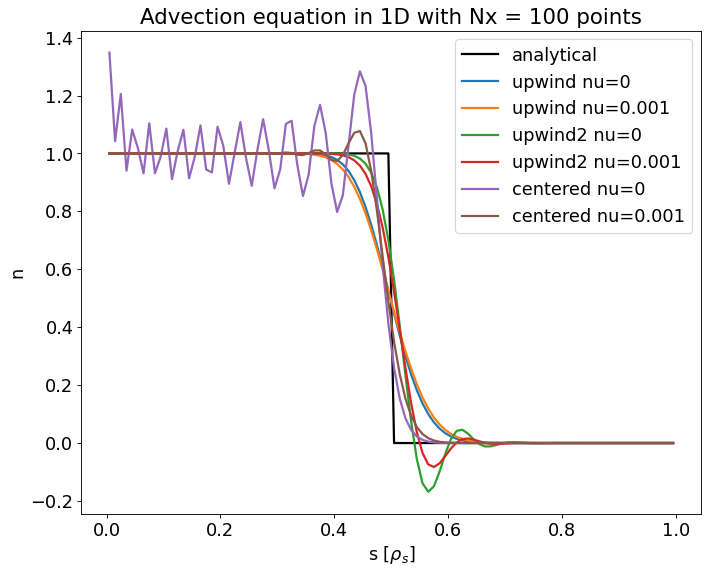

In [5]:
p_list = []
for p in ["upwind","upwind2", "centered"] :
    for nu in [0, 1e-3]:
        params = make_continuity_input()
        params["grid"]["Nx"] = 100
        params["advection"]["type"] = p
        params["physical"]["nu"] = nu
        p_list.append(params)
plot_upwind(p_list)

We find the expected results:
- the upwind scheme of first order does not produce oscillations and has inherent numerical diffusion
- the upwind scheme of 2nd order produces oscillations downstream
- the centered scheme without diffusion is unconditionally unstable and produces lots of oscillations
- only the first order upwind and the 2nd order schemes with diffusion produce smooth solutions
- adding the correct amount of numerical diffusion to the 2nd order schemes depends on the resolution

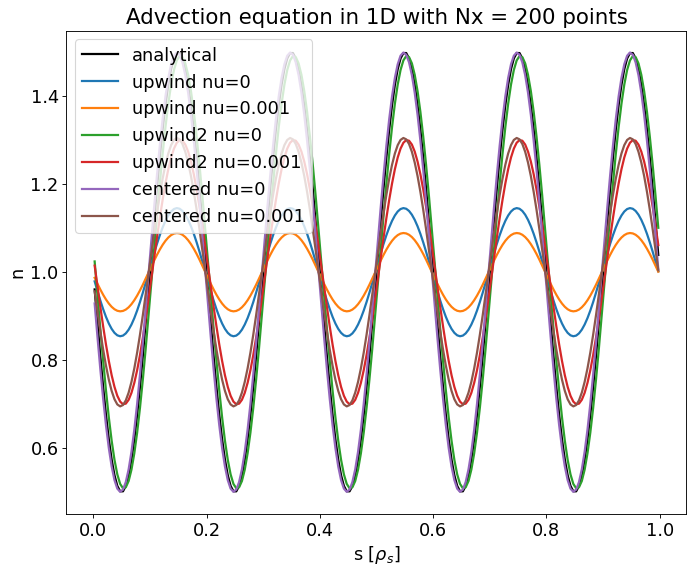

In [6]:
p_list = []
for p in ["upwind","upwind2", "centered"] :
    for nu in [0, 1e-3]:
        params = make_continuity_input()
        params["grid"]["Nx"] = 200
        params["grid"]["bc"] = "PER"
        params["output"]["tend"] = 0.5
        params["init"] = {"type" : "wave", "amp" : 0.5,
                          "n_0" : 1, "k" : 10*np.pi, "x_0" : 0}
        params["advection"]["type"] = p
        params["physical"]["nu"] = nu
        p_list.append(params)
plot_upwind(p_list)

In the wave example we can see that
- the upwind scheme of 1st order has a lot of numerical diffusion (even more than the artificial diffusion)
- the schemes with diffusion are stable but they do not converge to the correct solution
- the 2nd order schemes seem to be stable without diffusion (which is a wrong conclusion as we know that centered differences are unstable, we conclude that the sine wave is not a good test function to test stability)



### Navier stokes equation

We now turn to the one-dimensional compressional Navier-Stokes equation
 \begin{align}
     \frac{\partial }{\partial t} n&= - \frac{\partial}{\partial x} (un ) + \nu_n\frac{\partial^2}{\partial x^2} n \\
     \frac{\partial }{\partial t} nu&= - \frac{\partial}{\partial x} nu^2 - \alpha\frac{\partial}{\partial x} n^\gamma + \nu_u\frac{\partial^2}{\partial x^2} u
 \end{align}
 
 For $\gamma=1$ and $\alpha=\tau$ these are the equations for an ideal gas in 1d,
 while for $\gamma=2$ and $\alpha=0.5g$ we get the shallow water equations.
 
 A numerically particularly challenging initial condition is the Riemann problem
 \begin{align}
 n(x,0) = \begin{cases} n_l \text{ for } x < x_a \\
 n_r \text{ else}
 \end{cases} \\
 u(x,0) = \begin{cases} u_l \text{ for } x < x_a \\
u_r \text{ else}
\end{cases}
 \end{align}
 For $\gamma=1$ this leads to Sod's shock tube problem while for $\gamma=2$ and $u_l = u_r = 0$ we have 
 a dam break over a dry/wet bed. Both these cases are widely discussed in the literature and have
 analytical solutions {cite}`Delestre2013` for the shallow water case.
 
 We intend to study various schemes to discretize these equations. We will start with the usual naive finite difference approximations, using centered
 differences for all derivatives as well as an upwind scheme for the continuity equation (keeping centered differences for the
 velocity equation). These are the schemes that we used for our Feltor simulations in the past.
 
A more robust approach is to use a so-called **staggered grid** discretization. This is a finite-volume type scheme and the 
basic idea is to shift the velocity grid by half a grid-point
such that the density is given on cell-centres while the velocity
is given on the faces. (The previous schemes where all quantities
are cell-centered is then called a collocated scheme).
Of the staggered discretizations, a particularly robust one seems
to be the one presented in {cite}`Herbin2013` and the PhD thesis of {cite}`Gunawan2015` where favourable qualities are shown:
- it is **positivity preserving**
- it is shown to satisfy an **entropy inequality**
- it is **shock-capturing**

The defining features of the scheme is that the pressure term $\alpha\partial_x n^\gamma$ in the momentum equation is discretized
implicitly and that the momenum form is discretized instead of the velocity formulation. This makes the scheme **semi-implicit**, however the
implicit equation can be trivially solved since the density and momentum equations decouple.

We study various variations of the scheme including taking the pressure term explicitly and discretizing the velocity form. There
is also a 2nd order formulation using a **slope-limiter** proposed in {cite}`Gunawan2015`.

```{bibliography} references.bib
```

In [7]:
# The code navier_stokes.cpp discretizes the above equations
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_navier_stokes_input() :
    return {
    "grid" : {
        "Nx" : 32, # number of grid points
        "x" : [0, 1], # spatial domain [x_0,x_1]
    },
#     "init":
#     {
#         # A sine wave in density with 0 velocity
#         "type" : "wave",
#         "amp" : 0.5,
#         "n_0" : 1,
#         "k" : 4*np.pi,
#         "x_0" : 0
#     },
    "init":
    {
        "type" : "step", # same as riemann with 0 velocity
        "x_a" : 0.5, # location of jump
        "n_l" : 1,   # density left of jump
        "n_r" : 0.2, # density right of jump
        # Analytical solution only for gamma : 2
    },
#     "riemann":
#     {
#         "type" : "step",
#         "x_a" : 0.2, # location of jump
#         "n_l" : 1,   # density left of jump
#         "n_r" : 10, # density right of jump
#         "u_l" : 5,   # density left of jump
#         "u_r" : 7.5, # density right of jump
#     },
#     "init":
#     {
#          # Manufactured solution without shock
#         "type" : "mms",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "k" : 4*np.pi,
#         "v" : 1
#         # Analytical solution only for gamma : 1
#     },
    "advection" : 
    {
        "type" : "staggered", 
        # upwind
        # upwind2
        # centered
        # staggered (allows variant)
        # velocity-staggered (allows variant)
        "variant" : "original"
        # original (The original scheme, 1st order)
        # explicit (Take pressure term explicitly)
        # slope-limiter (Use 2nd order flux)
        # slope-limiter-explicit (Use 2nd order flux
        #     and pressure term explicit)
    },
    "timestepper":
    {
        # The Additive Runge Kutta (ARK) method is a semi-implicit
        # embedded Runge Kutta scheme that works for all (explicit
        # and implicit) advection schemes above
        "type" : "ARK",
        "tableau" : "ARK-4-2-3",
        "rtol" : 1e-6, # relative tolerance
        "atol" : 1e-7  # absolute tolerance
        # The Embedded Runge Kutta (ERK) only works 
        # for explicit schemes
        # "type" : "ERK", 
        # "tableau" : "Bogacki-Shampine-4-2-3"
    },
    "physical":
    {
        "nu_u" : 0.0, # viscosity
        "nu_n" : 0.0, # diffusivity (can be used to stabilize)
#         "gamma" : 1,
#         "alpha" : 1 
        # Shallow water equations:
        "gamma" : 2, 
        "alpha" : 9.81/2.0  # half the gravity
    },
    "bc" :
    {
         # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
        "density": "NEU",
        "velocity" : "NEU"
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.025, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }

In [8]:
# This works completely analogous to the continuity case above
rep = simplesim.Repeater("./navier_stokes","temp.json", "temp.nc")
rep.clean()
rep.run( make_navier_stokes_input(), error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")

ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Number of failed steps
duration (21,) 	Computation time for the latest output (i.e. nsteps timesteps)
nsteps (21,) 	Number of calls to the timestepper (including failed steps)
density (21, 32) 	Numerical density
velocity (21, 32) 	Numerical velocity
density_ana (21, 32) 	Analytical solution to the density
velocity_ana (21, 32) 	Analytical solution to the velocity


In [9]:
# Again, we define a plotting routine that loops over
# parameters sets, runs simulations and plots the results
def plot_navier_stokes( p_list):
    frows = 2
    fcols = 2

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display", stdout="ignore")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        nsteps = sum(var["nsteps"][:])
        error = var["density"][:,:] - var["density_ana"][:,:]
        norm_ana = np.linalg.norm( var["density_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])
        if not norm_ana == 0:
            print( f"L2 Error norm is {np.linalg.norm(error[last_idx,:], ord=1)/norm_ana}")

        # Compute entropy
        entropy = 0.5 * var["density"][:,:]*var["velocity"][:,:]**2
        if( p["physical"]["gamma"] == 1) :
            entropy = entropy + p["physical"]["alpha"] *var["density"][:,:]*np.log( var["density"][:,:])
        else :
            entropy = entropy + p["physical"]["alpha"]/(p["physical"]["gamma"]-1
                                                       ) *var["density"][:,:]**p["physical"]["gamma"]
        x = var["x"][:]

        if not plotted and not norm_ana == 0:
            im = ax[0][0].plot(x, var["density_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            im = ax[0][1].plot(x, var["velocity_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            plotted = True
        l = f"{p['advection']['type']}"
        if( "variant" in p["advection"].keys() ):
            l = l + f" {p['advection']['variant']}"
            
        print( f"Timesteps for {l} is {nsteps}")
        im = ax[0][0].plot(x,var["density"][last_idx,:], label=l, lw=4)
        im = ax[0][1].plot(x,var["velocity"][last_idx,:], label=l, lw=4)
        im = ax[1][0].plot( var["time"][:], np.trapz( entropy[:,:], x, axis = 1), lw=4)
        ncin.close()
    ax[0][0].set_title( f"density Nx = {p['grid']['Nx']}")
    ax[0][0].set_xlabel( r"s [$\rho_s$]")
    ax[0][0].set_ylabel("n")
    ax[0][0].legend()
    ax[0][1].set_title( f"velocity")
    ax[0][1].set_xlabel( r"s [$\rho_s$]")
    ax[0][1].set_ylabel("u")
    ax[1][0].set_title( f"Global entropy conservation")
    ax[1][0].set_xlabel( "t")
    ax[1][0].set_ylabel( r"$\eta$")
    ax[0][1].legend()
    

As a first example we study the dam break over a dry bed without viscosity

L2 Error norm is 0.016547307519531047
Timesteps for staggered explicit is 28325.0
L2 Error norm is 0.020440380461793174
Timesteps for staggered slope-limiter-explicit is 33036.0
L2 Error norm is 0.03289254253473707
Timesteps for upwind is 27066.0
L2 Error norm is 0.02447567064333379
Timesteps for velocity-staggered explicit is 35110.0
L2 Error norm is 0.01862201985470986
Timesteps for upwind2 is 30602.0


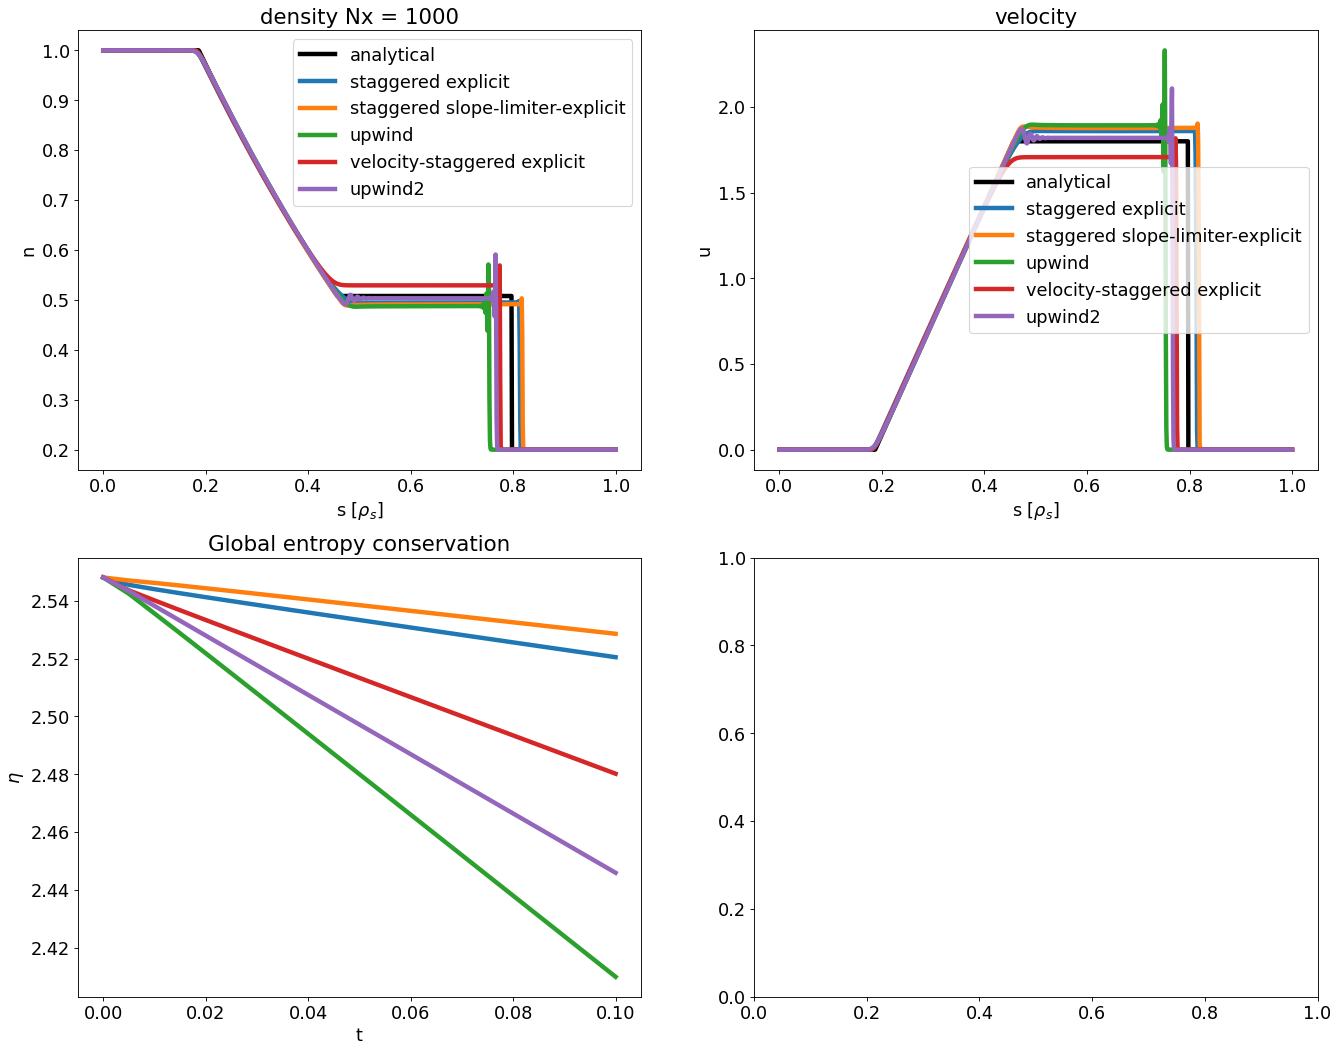

In [10]:
p_list = []
for p in [{"type" : "staggered", "variant" : "explicit"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "upwind", "regularization" : "none"},
    {"type" : "velocity-staggered", "variant" : "explicit"},
 {"type" : "upwind2"},
#  {"type" : "centered"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 1000
    params["output"]["tend"] = 0.1
#     params["physical"]["nu_u"] = 0.01
    #params["physical"]["gamma"] = 1
    #params["physical"]["alpha"] = 1
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

We see that even with very high resolution
- none of the explicit schemes converges to the correct solution
- only the staggered schemes are free of oscillations
- we are unable to reproduce Figure 1.6 in Gunawan's thesis (even after trying to use fixed-step Euler scheme in order to exclude effects from the different timestepper we use)

L2 Error norm is 0.002011511414451985
Timesteps for staggered implicit is 22242.0
L2 Error norm is 0.0004671340198497355
Timesteps for staggered slope-limiter is 27270.0
L2 Error norm is 0.024475696911053158
Timesteps for velocity-staggered implicit is 32547.0


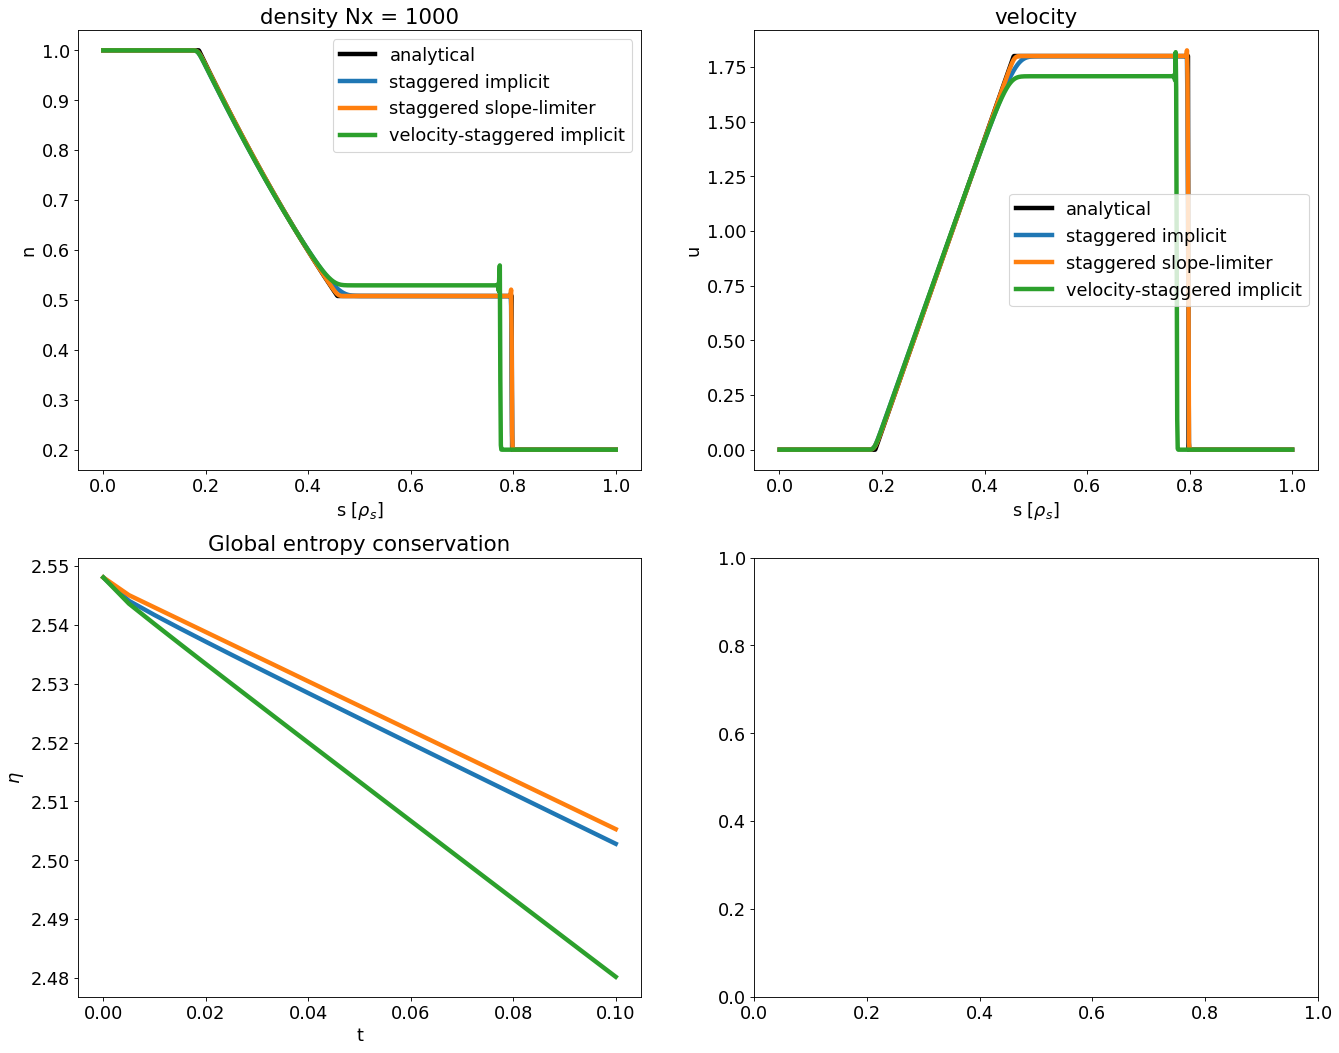

In [11]:
p_list = []
for p in [{"type" : "staggered", "variant" : "implicit"},
    {"type" : "staggered", "variant" : "slope-limiter"},
    {"type" : "velocity-staggered", "variant" : "implicit"},
        ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 1000
    params["output"]["tend"] = 0.1
#     params["physical"]["nu_u"] = 0.01
    #params["physical"]["gamma"] = 1
    #params["physical"]["alpha"] = 1
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

- the original schemes of 1st and 2nd order converge to the correct solution as advertised
- the staggered velocity scheme does not

Timesteps for staggered implicit is 6112.0
Timesteps for staggered slope-limiter is 12311.0
Timesteps for staggered explicit is 5753.0
Timesteps for staggered slope-limiter-explicit is 12333.0


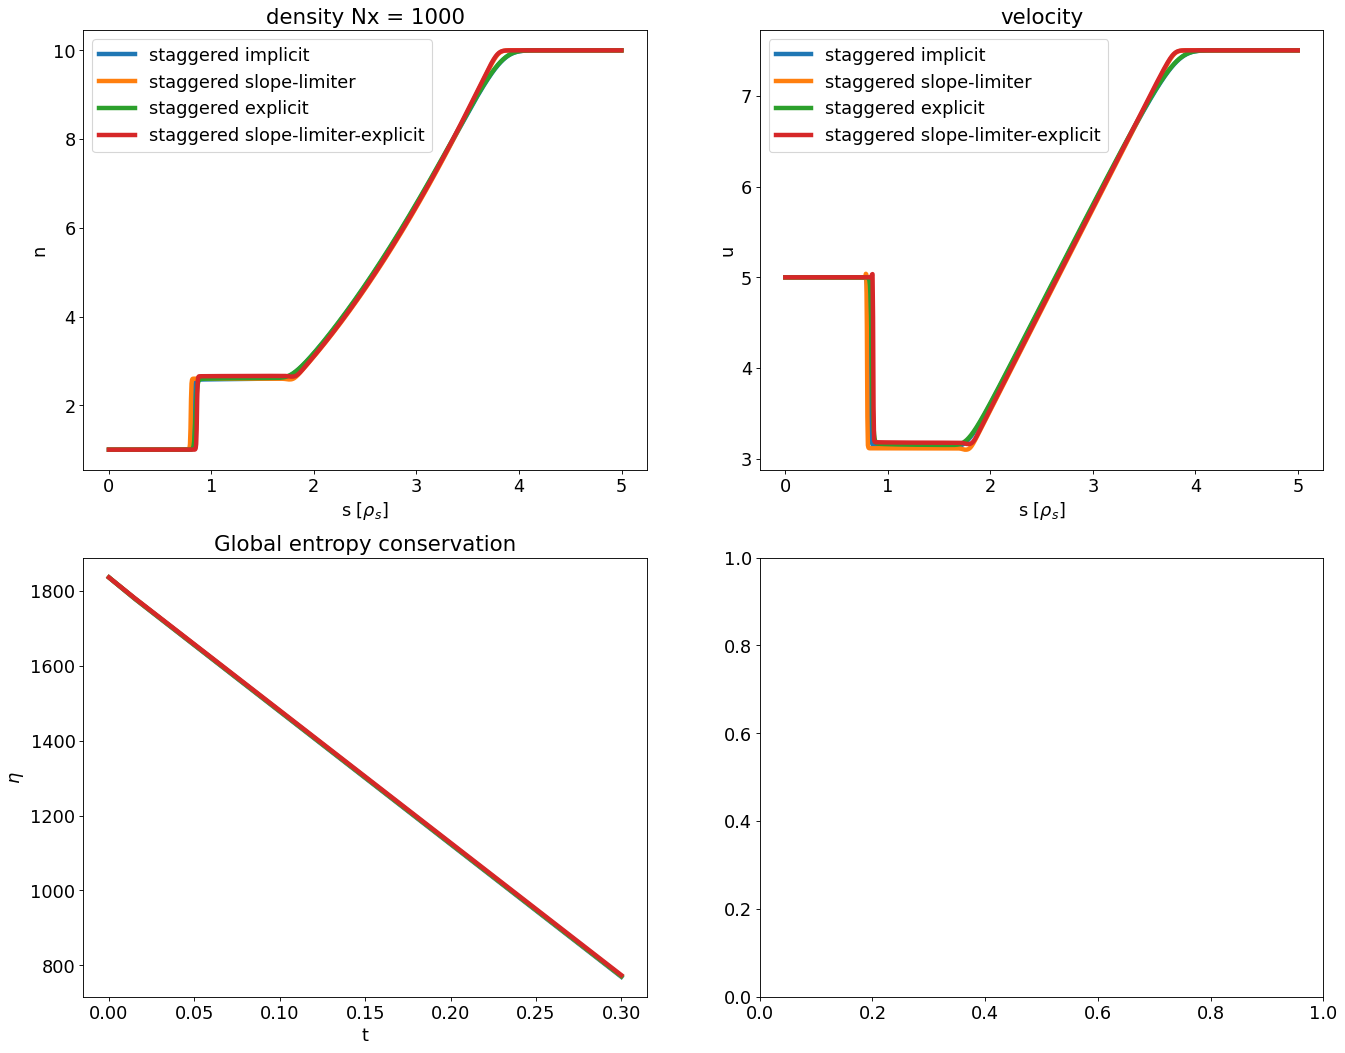

In [12]:
# Here, we try to reproduce the plot in Herbin that explicit schemes have a non-entropic solution
# (which we cannot)
p_list = []
for p in [{"type" : "staggered", "variant" : "implicit"},
    {"type" : "staggered", "variant" : "slope-limiter"},
          {"type" : "staggered", "variant" : "explicit"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 1000
    params["grid"] ["x"] = [0,5]
    params["init"] = {
        "type" : "riemann",
        "x_a" : 0.2,
        "n_l" : 1,
        "n_r" : 10,
        "u_l" : 5,
        "u_r" : 7.5
    }
    
    params["output"]["tend"] = 0.3
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["physical"] ["alpha"] = 1
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Euler"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

Timesteps for centered is 13375.0
Timesteps for staggered slope-limiter is 13476.0
Timesteps for staggered slope-limiter-explicit is 15175.0


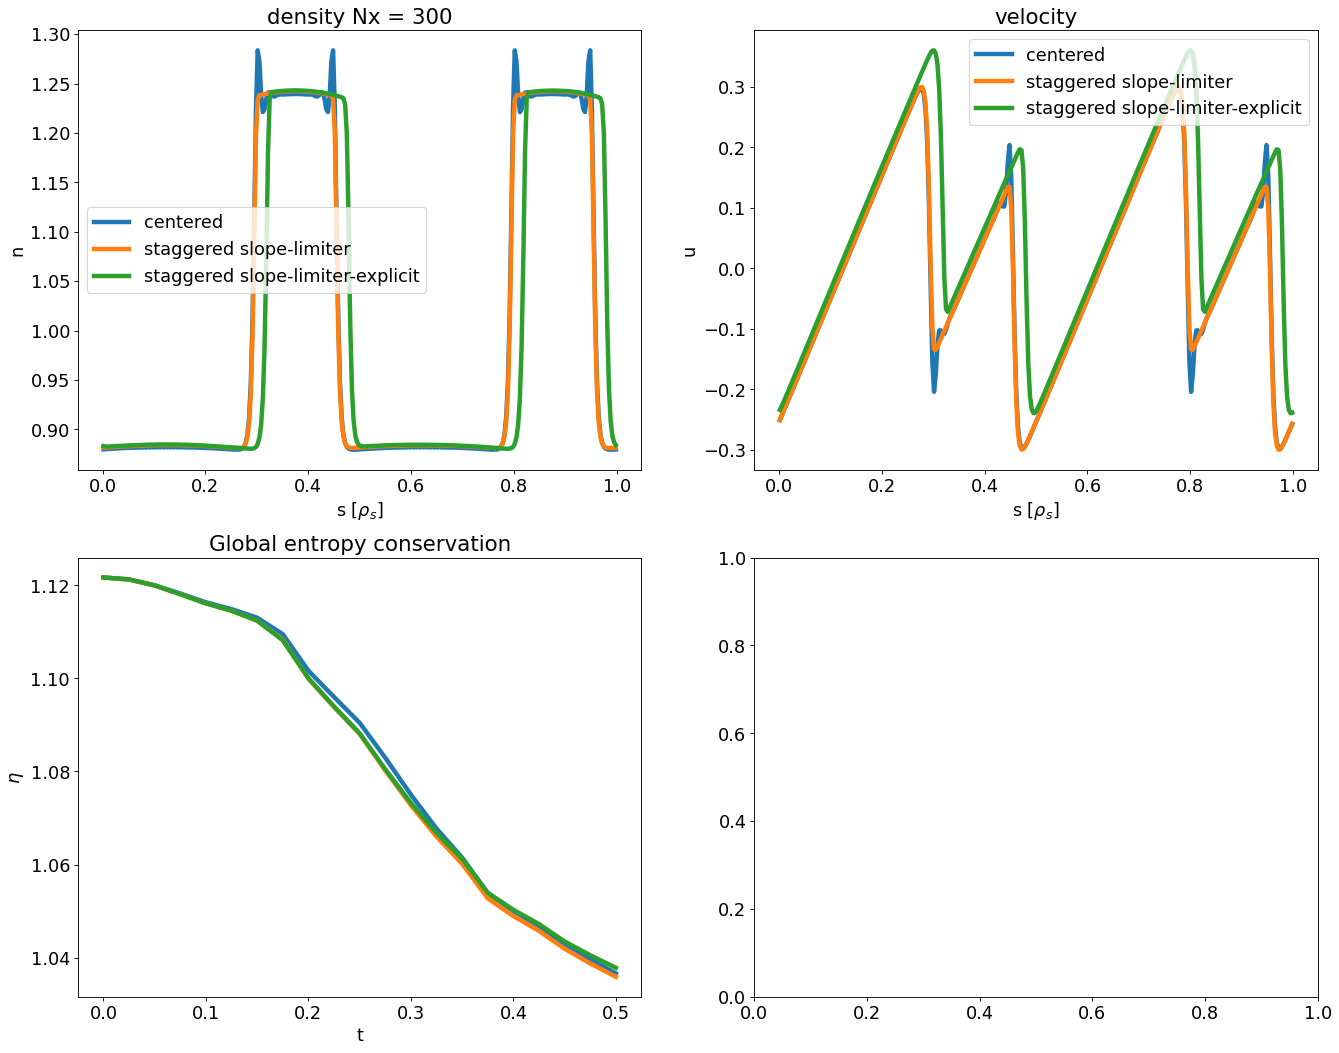

In [13]:
p_list = []
for p in [
    {"type" : "centered"},
    {"type" : "staggered", "variant" : "slope-limiter"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"}
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 300
    params["init"] = {
        # A sine wave in density with 0 velocity
        "type" : "wave",
        "amp" : 0.5,
        "n_0" : 1,
        "k" : 4*np.pi,
        "x_0" : 0
    }
    params["bc"] = {"density" : "PER", "velocity" : "PER"}
#     params["physical"]["nu_n"] = 0.002
    params["physical"]["nu_u"] = 0.002
    params["output"]["tend"] = 0.5
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["physical"] ["alpha"] = 1
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Euler"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

Here we initialize a plane wave in the density and 0 velocity and add a small viscosity. The example shows that
- shocks can form due to burgers term (the wave top moves faster than the wave bottom, steepening the front)
- if the viscosity is too small the centered scheme cannot compete
- we here see that in the explicit staggered scheme the velocity seems to gain energy over time (even though the effect lessens when the resolution is increased)

In [14]:
# The mms method is to check that all terms are implemented correctly
p_list = []
for p in [
    {"type" : "staggered", "variant" : "original"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "upwind", "regularization" : "none"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "upwind2"},
    {"type" : "centered"},
         ] :
    for Nx in [100,200,400,800,1600,3200]:
        params = make_navier_stokes_input()
        params["grid"]["Nx"]= Nx
        params["output"]["tend"] = 0.1
        params["init"] = {
             # Manufactured solution without shock
            "type" : "mms",
            "n_0" : 1,
            "u_0" : 0.5,
            "A" : 0.2,
            "B" : 0.1,
            "k" : 4*np.pi,
            "v" : 1
            # Analytical solution only for gamma : 1
        }
        params["bc"] = {"density":"PER", "velocity" : "PER"}
        params["physical"]["nu_u"] = 0.0
        params["physical"]["gamma"] = 1
        params["physical"]["alpha"] = 1
        params["timestepper"]["type"] = "ARK"
        params["timestepper"]["tableau"]  = "ARK-4-2-3"
        params["advection"] = p
        rep.clean()
        rep.run( params)
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        error = var["density"][:,:] - var["density_ana"][:,:]
        norm_ana = np.linalg.norm( var["density_ana"][last_idx,:], ord=1)
        l = f"{params['advection']['type']}"
        if( "variant" in params["advection"].keys() ):
            l = l + f" {params['advection']['variant']}"
        print( f"{l} {Nx} {np.linalg.norm(error[last_idx,:], ord=1)/norm_ana}")
        ncin.close()

#plot_navier_stokes(p_list)

staggered original 100 0.004072477614311855
staggered original 200 0.0020872101265738486
staggered original 400 0.0010567156976690674
staggered original 800 0.000531758873986143
staggered original 1600 0.000266713864045338
staggered original 3200 0.00013356514964580647
staggered slope-limiter-explicit 100 0.0004412136384010058
staggered slope-limiter-explicit 200 0.00011217105913504389
staggered slope-limiter-explicit 400 2.755709408567952e-05
staggered slope-limiter-explicit 800 6.818134173759149e-06
staggered slope-limiter-explicit 1600 1.8600274441460395e-06
staggered slope-limiter-explicit 3200 1.0381292494278382e-06
upwind 100 0.0034299389720005213
upwind 200 0.0017941811450401463
upwind 400 0.0009182384823464379
upwind 800 0.00046457031291015084
upwind 1600 0.0002336202755605704
upwind 3200 0.00011714601848953891
velocity-staggered slope-limiter-explicit 100 0.0003423806864733193
velocity-staggered slope-limiter-explicit 200 8.542280659213863e-05
velocity-staggered slope-limiter-

In [15]:
%matplotlib notebook
params = make_navier_stokes_input()
params["grid"]["Nx"]= 1000
params["grid"]["x"] = [0,5]

params["output"]["tend"] = 0.5

params["advection"] = {"type" : "staggered"}
params["output"]["maxout"] = 200
params["init"] ["x_a"] = 2.5
# Run simulation
rep.clean()
rep.run( params, error="display", stdout="ignore")

ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
xc = ncin["x"][:]
time = ncin["time"][:]
density = ncin["density"][0,:]
fig = plt.figure(figsize=(9, 3))
quad, = plt.plot(xc,density)


plt.axis('scaled')

frames = params["output"]["maxout"]
def animate(iter):
    dens = ncin["density"][iter,:]
    plt.title(r"$n(x,t)\ t=%0.2f$"%time[iter])
    quad.set_data( xc, dens)
    return quad

ani = animation.FuncAnimation(fig,animate,frames=frames,interval=2,blit=True,repeat=True)
# plt.show()
writer = animation.writers['ffmpeg'](fps=50)

ani.save('breaking_dam_on_wet_bed.mp4',writer=writer,dpi=100)

<IPython.core.display.Javascript object>

In [16]:
%matplotlib inline
# # These parameters are for a Tokamak
# show = ["name", "mu", "R_0", "a_0", "beta", "resistivity",
#         "T_e", "n_0", "B_0", "CFL_diff", "epsilon_D",
#         "omega_0_inv", "viscosity_e", "viscosity_i", "rho_s"]
# physical={"name" : "Compass",
#     "beta" : 1e-4, "resistivity": 1e-4, #change both to change n_0
#     "tau" : 1,
#     "m_i" : fp.deuteron_mass, "R_0" : 545, "R": 0.545,
#     "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32}
# fp.numerical2physical( physical, physical)
# table = dict()
# for s in show :
#     table[s] = fp.parameters2quantity( physical, s)
#     if s == "omega_0_inv":
#         table[s] = 1e-3/fp.parameters2quantity( physical, s)
#     print( s, "\t\t", table[s])
# table["lx"] = 2*np.pi*table["R_0"]*3
# print( "lx", "\t\t", table["lx"])